# DSP Core Functions and Logic Flow

In [575]:
import numpy as np
from numpy import fft as fft
import matplotlib.pyplot as plt
import scipy.signal as signal


## Remove Baseline and Check for Anomalies:
Goal is to quickly find anomalies and filter out any baseline signals in the phase angle and Marine Resistivity data components from the signals. The most reduced, compressed output format possible is best. 

In [576]:
# Make simulated "baseline" signals and process them with dsp()
def simulate_squares(number_of_channels, dc_offset_max, dc_offset_min,
                              amplitude_max, amplitude_min):
    N = 8192  # number of samples
    T = 1 # Sampling period (seconds)
    f_s = 8192  # [Samples/second]
    t = np.linspace(0, N-1, N, endpoint=False)
    offsets = np.random.randint(low=1, high=60, size=number_of_channels)    
    # define the matrix of signals.
    
    all_channel_wavepacket = np.empty((N, number_of_channels))
    
    for j in range(number_of_channels):
        TIME_OFFSET = N / offsets[j]  # time offset provided for simulation
        AMP = np.random.randint(amplitude_min, amplitude_max)  # amplitude (in ADC values)
        NOISE_LVL = AMP / np.random.randint(low=10, high=40)  # Naive way to set noise on the signal (not true SNR)
        DC_OFFSET = np.random.randint(dc_offset_min, dc_offset_max)  # DC offset in ADC values
        F_tx = 4.00  # Fundamental frequency of the waveform (Hz)
        noise = NOISE_LVL * np.random.normal(0, 1, t.shape)
        pure_sig = AMP * signal.square(2 * np.pi * F_tx * t - TIME_OFFSET) + NOISE_LVL * np.sin(np.pi* 60 *t) + DC_OFFSET
        sig = pure_sig + noise
        all_channel_wavepacket[:, j] = sig
    return t, all_channel_wavepacket

In [577]:
# Plotting the waveforms as a sanity check:
def plot_all_waveforms(t, signals):
    domain_size = t.shape[0]
    plt.figure(figsize=(20,20))
    number_of_channels = signals.shape[-1]
    for p in range(number_of_channels):
        plt.plot(t, signals[:, p], label='Channel %s' % p)
    plt.title(f"Simulation of {number_of_channels} Randomly Generated Square Waves for DSP Analysis")
    plt.xlabel('Sample Domain')
    plt.ylabel('Sample ADC Value')
    plt.grid(True)
    plt.legend()
    plt.show()

In [578]:
# Simulate 6 channels of baseline noisy data with variable offsets within certain ranges.
q_channels = 6  # number of channels
T = 1 # Sampling period (seconds)
f_s = 8192  # [Samples/second]
# Random parameter ranges
base_offset_max = 4000
base_offset_min = -4000
base_amp_max = 4000
base_amp_min = 500

t_domain, baseline_packets = simulate_squares(q_channels, base_offset_max, base_offset_min,
                                base_amp_max, base_amp_min)

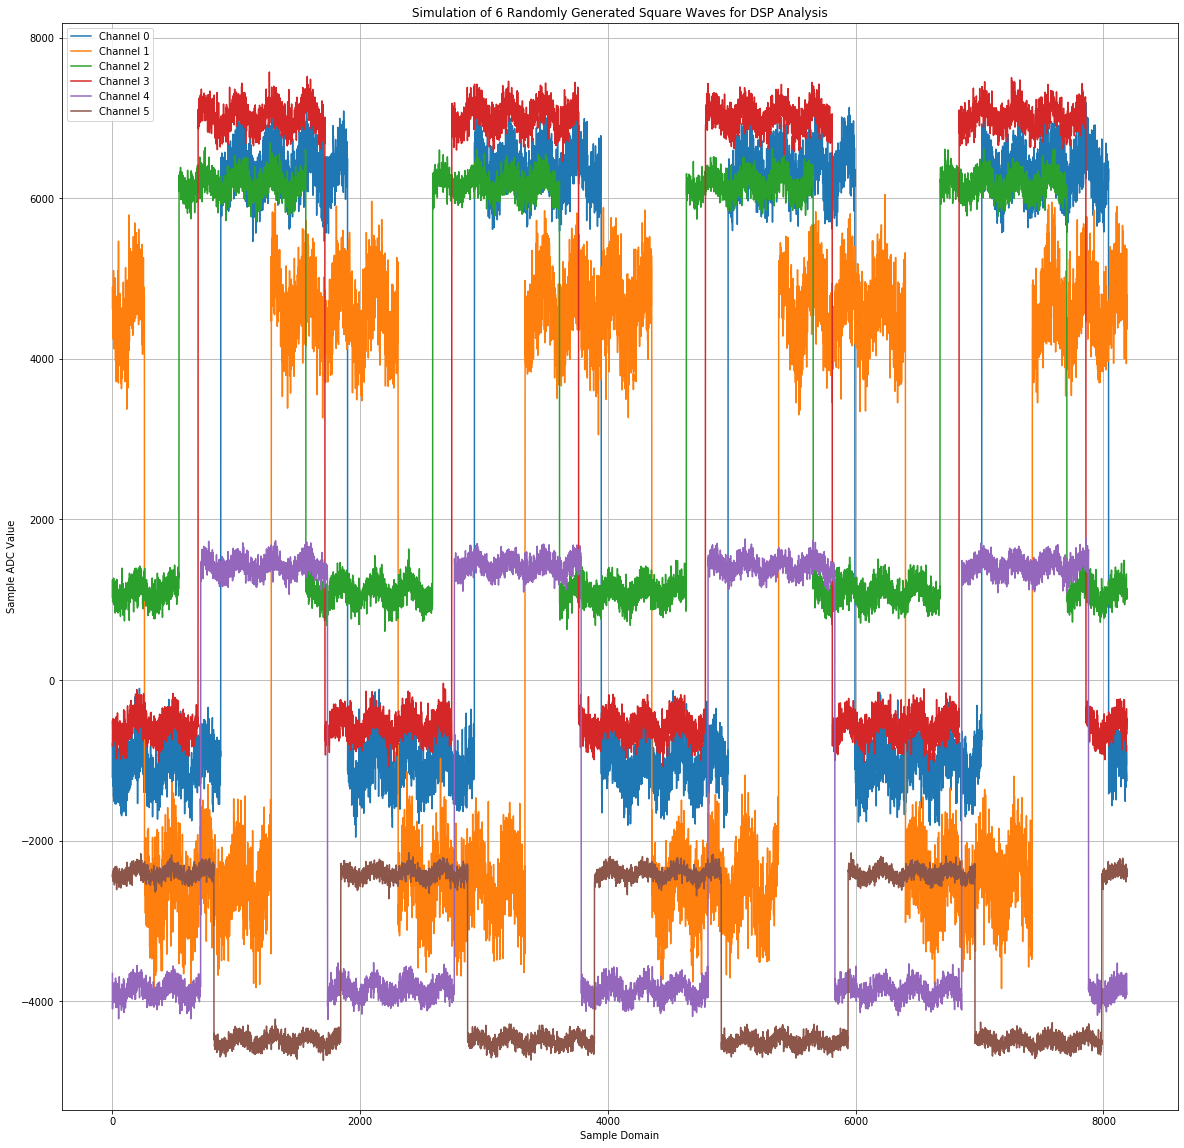

In [579]:
# Sanity Check plot
plot_all_waveforms(t_domain, baseline_packets)

In [580]:
def remove_dc_offset(sig):
#     print(f"sig.shape = {sig.shape}")
    q_channels = sig.shape[-1]
    for q in range(0, q_channels):
        offset_average = np.average(sig[:, q])
#         print(f"Waveform Average Value for Channel [q] = {offset_average}")
        sig[:, q] = sig[:, q] - offset_average
    return sig

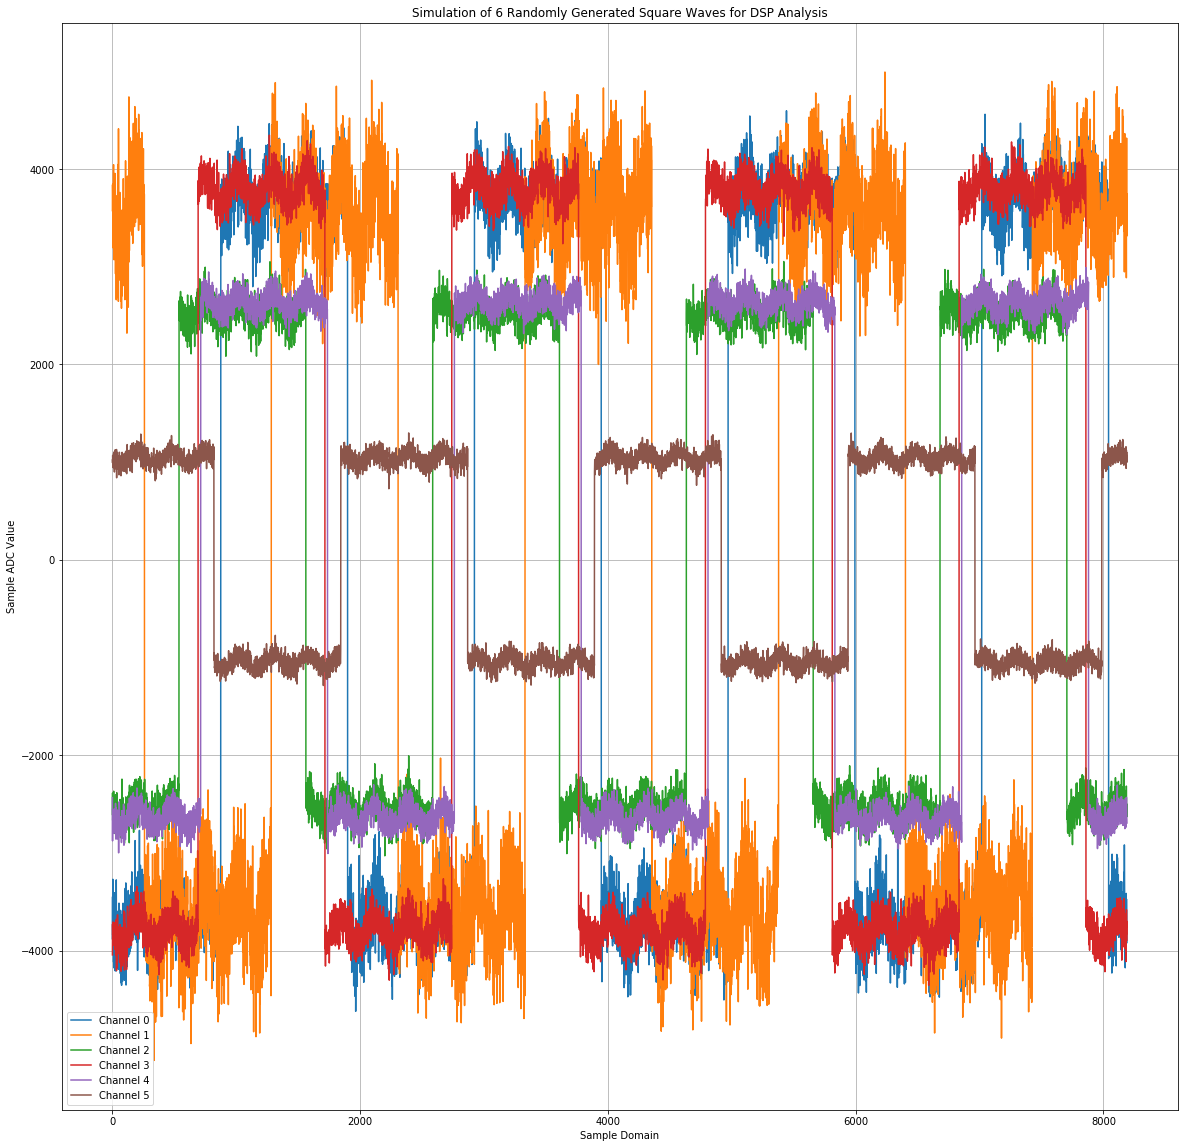

In [581]:
# Sanity  check that offset removal still works...
ac_baseline_packets = remove_dc_offset(baseline_packets)
plot_all_waveforms(t_domain, ac_baseline_packets)

  ## Filtering 

In [582]:
def butterworth_digital_lpf(sig, n_samples, f_sample, f_order, f_cut, analysis_plot=False):
    """
    .. function:: butterworth_analog_lpf
    .. description::
    :param sig:
    :param order:
    :param f_cut:
    :return w:
    :return h:
    :return filt_sig:
    """
    # Define second-order sections representation of the IIR filter.
    sos = signal.butter(f_order, f_cut, 'lp', fs=f_sample, analog=False, output='sos')
    # Apply the filter to our signal.
    filt_sig = signal.sosfilt(sos, sig)
    
    if analysis_plot:
        # Compute the numerator and denominator polynomials of the IIR filter.
        b, a = signal.butter(f_order, f_cut, 'lp', fs=f_sample, analog=False)
        # Compute the frequency response of an analog filter.
        w, h = signal.freqs(b, a)
        # and plot results:
        t = np.linspace(0, n_samples - 1, n_samples)
        plot_wave_freqresp_filter(t, sig, filt_sig, w, h, f_order, f_cut)

    return filt_sig

In [583]:
def plot_wave_freqresp_filter(t, s, filt_s, w, h, f_order, f_c):
    """
    .. function:: plot_wave_freqresp_filter
    .. description::
    :param t:
    :param s:
    :param filt_s:
    :param w:
    :param h:
    :param order:
    :param f_c:
    :return NONE:
    """
    plt.figure(figsize=(17, 5))
    
    # Raw Waveform
    plt.subplot(131)
    plt.plot(t, s)
    plt.title('Raw Waveform')
    plt.xlabel('Sample Domain')
    plt.ylabel('Sample ADC Value')
    plt.grid(True)
    
    # Filtered Waveform
    plt.subplot(132)
    plt.plot(t, filt_s)
    plt.title('Filtered Waveform Copy')
    plt.xlabel('Sample Domain')
    plt.ylabel('Sample ADC Value')
    plt.grid(True)
    
    # Butterworth Filter BODE plot (Right Subplot)
    plt.subplot(133)
    plt.semilogx(w, 20*np.log10(abs(h)))
    plt.title(f'{f_order}-Order \n Butterworth Filter \n Frequency Response')
    plt.xlabel('Frequency [rad/s]')
    plt.ylabel('Amplitude [dB]')
    plt.margins(0, 0.1)
    plt.grid(which='both', axis='both')
    plt.axvline(f_c, color='green') # cutoff frequency
    
    plt.tight_layout()
    plt.show()

## Triggering

In [584]:
def rising_edge_trigger(filt_zeroed_sig, filt_sig_gradient, gradient_max, N):
    """
    """
    positive_trigger_indices = (j for j in range(N - 1) if 
                           ((filt_sig_gradient[j] >= (2/3) * gradient_max) and
                            filt_zeroed_sig[j - 1] < filt_zeroed_sig[j]))
    t0 = next(positive_trigger_indices)
#     print(f"First rising trigger found at index {t0}!")
    return t0

In [585]:
def falling_edge_trigger(filt_zeroed_sig, filt_sig_gradient, gradient_max, N):
    """
    """
    negative_trigger_indices = (j for j in range(N-1, 0, -1)  if 
                            ((filt_sig_gradient[j] <= (2/3) * -gradient_max) and
                             filt_zeroed_sig[j + 1] < filt_zeroed_sig[j]))
    tf = next(negative_trigger_indices)
#     print(f"Last falling trigger found at index {tf}!")
    return tf

In [586]:
def set_triggers(s_t_matrix, f_s, filter_order, filter_cut, analysis_plot):
    """
    .. function: set_triggers:
    .. description::
    :param s_t_matrix:
    :param filter_order:
    :param filter_cut:
    :return t0s:
    :return nlengs:
    """
    # definitions:
    q_channels = s_t_matrix.shape[-1]
    n_raw = s_t_matrix.shape[0]
    t0s = []
    nlengs = []
    
    # for each channel-q:
    for q in range(0, q_channels):
        # filter
        filt_signal = butterworth_digital_lpf(s_t_matrix[:, q], n_raw, f_s, filter_order, filter_cut, analysis_plot)
        # compute gradient and max gradient value of filtered signal
        filt_g_signal = np.gradient(filt_signal)
        g_max = np.nanmax(filt_g_signal)
        n_filt = filt_signal.shape[0]
        # get first positive trigger t0q
        t0q = rising_edge_trigger(filt_signal, filt_g_signal, g_max, n_filt)
        # get last negative trigger tfq
        tfq = falling_edge_trigger(filt_signal, filt_g_signal, g_max, n_filt)
        t0s.append(t0q)
        nlengs.append(np.abs(tfq - t0q))
    return t0s, nlengs

In [587]:
def shift_signal_to_triggers(time_series_q, t0q, n_min):
    """
    .. function:: shift_signals_to_triggers
    .. description::
    :param time_series_q:
    :param t0q:
    :param n_min:
    :return channel_out:  Output array of length `n_min` for channel-q shifted to the global t0 and trimmed to match `n_min`.
    """
    return np.roll(time_series_q, -t0q)[0: n_min]

In [588]:
def time_series_conditioning(raw_time_series_matrix, f_s, f_order, f_cut, analysis_plot):
    """
    .. fucntion:: signal_conditioning
    .. description::
    :param time_series_matrix:
    :return win_sig_0: Trigger-windowed ORIGINAL noisy signals (no filters) array with offset removed and start times (t0q) for channel-q shifted to match using triggers. 
    """
    # definitions
    # number of channels q
    q_channels = raw_time_series_matrix.shape[-1]
    
    # Remove DC offsets
    zeroed_time_series_matrix = remove_dc_offset(raw_time_series_matrix)
    
    # Locate trigger times and return arrays of t_starts and n_lengths. Include filter parameters.
    t_starts, n_lengths = set_triggers(zeroed_time_series_matrix, f_s, f_order, f_cut, analysis_plot)
    
    # set the minimum trimmed length to match all channels-q
    n_min = np.nanmin(n_lengths)
    # adjust the minimum length to n_min - 1 if the value for n_min is odd (for simplifying FFTs later)
    if n_min % 2 != 0:
        n_min = n_min - 1
    
    # define complex output signal array based on `n_min` and `q_channels`
    output_signal_matrix = np.empty((n_min, q_channels), dtype=np.complex64)
    
    # Iteratively Shift signals in each channel over and truncate to match the others 
    # based on the start triggers and array lengths determined by `set_triggers()`
    for q in range(0, q_channels):    
#         print(f"Shifting signal start and trimming length for signal channel {q + 1}")
        output_signal_matrix[:, q] = shift_signal_to_triggers(raw_time_series_matrix[:, q], t_starts[q], n_min)
        
    # testprint
#     print(f"output_signal_matrix dimensions are now {output_signal_matrix.shape}...")
    return output_signal_matrix

In [589]:
def phase_difference_spectrum(s0k, sqk):
    """
    .. function:: phase_difference_spectrum()
    .. description:: Estimate the phase angle of each waveform and the associated shift between them, holding
    S_a(k) as a reference wavform and taking the difference of the derived phase arrays. 
    
    The phase shift corresponds to modulation of the complex part of the transmitted/
    received waveform, which is an indication of either inductive or capacitive frequency-
    dependent responses of the signal due to the electrical network betweewn the electrodes
    formed by the water and target. 
    
    Calculate the phase shift from a reference spectrum (sa_k) and a shifted spectrum (sb_k)
    
    :param s0k:
    :param sqk:
    :return phase_shift_spectrum:
    """
    phase0k = np.angle(s0k) 
    phaseqk = np.angle(sqk)
    phase_shift = np.subtract(phaseqk, phase0k)
    
    # Correct phase shift angles for values outside np.pi -- removes false positive/negative values.
    for m in range(phase_shift.shape[0]):
        if phase_shift[m] > np.pi:
            phase_shift[m] = 2.00 * np.pi - phase_shift[m]
        elif phase_shift[m] < -np.pi:
            phase_shift[m] = phase_shift[m] + 2.00 * np.pi
        else:
            continue
    
    return phase_shift

In [590]:
def apparent_impedance_spectrum(s0k, sqk):
    """
    Estimate the apparent impedance spectrum ||Z(k)||^2 for a shunt(s0_k) <--> RX Channel (sq_k) pair by taking the magnitude 
    of the difference between the two complex spectra. This yields the REAL part of the complex impedance of the target and water network
    between RX electrodes and removes the internal real impedance from the transmitter shunt. 
    
    :param s0k:
    :param sqk:
    :return zqk:
    """
    zqk = np.absolute(s0k - sqk)
    return zqk

In [591]:
# define a DSP signal processing function that calls the other relevant functions. 
def packet_dsp(t, s_t, period, f_s, filter_order=4, filter_cut=200, filter_analysis_plot=False):
    """
    .. function:: 
    .. description::
    :param t:
    :param s_t:
    :param tau:
    :param filter_order:
    :param filter_cut:
    :return k_domain:
    :return conditioned_time_series:
    :return marine_ip_k:
    :return marine_r_k:
    """
    # def time_series_conditioning(raw_time_series_matrix, f_s, f_order, f_cut, analysis_plot
    conditioned_time_series = time_series_conditioning(s_t, f_s, filter_order, filter_cut, filter_analysis_plot)
    number_of_channels = conditioned_time_series.shape[-1]
#     print("Now computing FFT, Marine Resistivity, and Marine IP Responses for the packet...")
    N_samples = conditioned_time_series.shape[0]
    # definitions for numpy arrays and constants
    tau = np.float(period / f_s)
    k_domain = fft.fftfreq(N_samples, tau)
    s_k = np.zeros((k_domain.shape[0], number_of_channels), dtype=np.complex64)
    marine_ip_k = np.zeros((k_domain.shape[0], number_of_channels), dtype=np.complex64)
    marine_r_k = np.zeros((k_domain.shape[0], number_of_channels), dtype=np.complex64)
    # iterate over all channels to compute the FFT, phase difference between shunt and channels, and apparent impedance spectra between channels
    for q in range(0, number_of_channels):
        # calculate frequency spectra
        # calculate the amplitude and normalize to y-domain [-1, 1]
        # 04-06-2020:  Added normalization to FFT output. 
        s_k[:, q] = (2.00 / N_samples) * fft.fft(conditioned_time_series[:, q])
        marine_ip_k[:, q]= phase_difference_spectrum(s_k[:,0], s_k[:,q])
        marine_r_k[:, q] = apparent_impedance_spectrum(s_k[:, 0], s_k[:, q])
    # verbose print
#     print(f"Yielded two matrices: marine_ip_k ({marine_ip_k.shape}) and marine_r_k ({marine_r_k.shape}))")
    return k_domain, conditioned_time_series, marine_ip_k, marine_r_k

In [592]:
def plot_phase_shift_and_magnitude(raw_signal, triggered_signal, k, marine_ip_k, marine_r_k):

    number_of_channels = raw_signal.shape[-1]
    t_raw = np.linspace(0, raw_signal.shape[0] - 1, raw_signal.shape[0], endpoint=False)
    t_triggered = np.linspace(0, triggered_signal.shape[0] - 1, triggered_signal.shape[0], endpoint=False)
    
    plt.figure(figsize=(20, 20))
    
    # Raw waveforms replotted for comparison. 
    plt.subplot(221)
    for p in range(number_of_channels):
        plt.plot(t_raw, raw_signal[:, p], label='Channel %s' % p if p != 0 else 'Transmit Shunt')
    plt.title(f"Simulation of {number_of_channels} Single Packet of \n Randomly Generated Square Waves for DSP Analysis")
    plt.xlabel('Sample Number')
    plt.ylabel('Shifted Sample ADC Value (Arb. Units)')
    plt.grid(True) 
    plt.legend()
    
    # Triggered, AC-only waveforms plotted for comparison.
    plt.subplot(222)
    for p in range(number_of_channels):
        plt.plot(t_triggered, triggered_signal[:, p], label='Channel %s' % p if p != 0 else 'Transmit Shunt')
    plt.title(f"Simulation of {number_of_channels} Single Packet of \n Randomly Generated Square Waves Shifted and Trimmed to Match\n in Signal Conditionining Stage")
    plt.xlabel('Sample Number')
    plt.ylabel('Shifted Sample ADC Value (Arb. Units)')
    plt.grid(True)
    plt.legend()
    
    # Triggered Phase Shift across all channels
    plt.subplot(223)
    for p in range(1, number_of_channels):
        plt.plot(fft.fftshift(k), fft.fftshift(marine_ip_k[:, p]), label='Channel %s' % p if p != 0 else 'Transmit Shunt')
    plt.title('Single Simulated Baseline Packet $p$ \n Marine IP Response $\Delta\phi_{p}(k)$ by Frequency')
    plt.xlabel('Frequency $\omega$ Domain radians/s')
    plt.ylabel('Corrected Phase Angle Deflection ${S_a}\angle{S_b}$ [Radians]')
    plt.xlim(0,200)
    plt.ylim(-np.pi, np.pi)
    plt.grid(True) 
    plt.legend()
    
    # Triggered ||Z||^2 across all channels
    plt.subplot(224)
    for p in range(1, number_of_channels):
        plt.semilogy(fft.fftshift(k), fft.fftshift(marine_r_k[:,p]), label='Channel %s' % p if p != 0 else 'Transmit Shunt')
    plt.title('Single Simulated Baseline Packet $p$ \n Marine Resistivity Response $||Z_{p}(k)||^{2}$ by Frequency')
    plt.xlabel('Frequency $\omega$ Domain radians/s')
    plt.ylabel('Spectral Intensity')
    plt.grid(which='both', axis='both') 
    plt.xlim(0,200)
#     plt.ylim(1000, np.max(fft.fftshift(marine_r_k[:200])))
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [593]:
k, conditioned_signals, marine_ip_k, marine_r_k = packet_dsp(t_domain, baseline_packets, T, f_s, filter_order=4, filter_cut=200)

/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/anaconda3/lib/python3.6/site-packages/numpy/

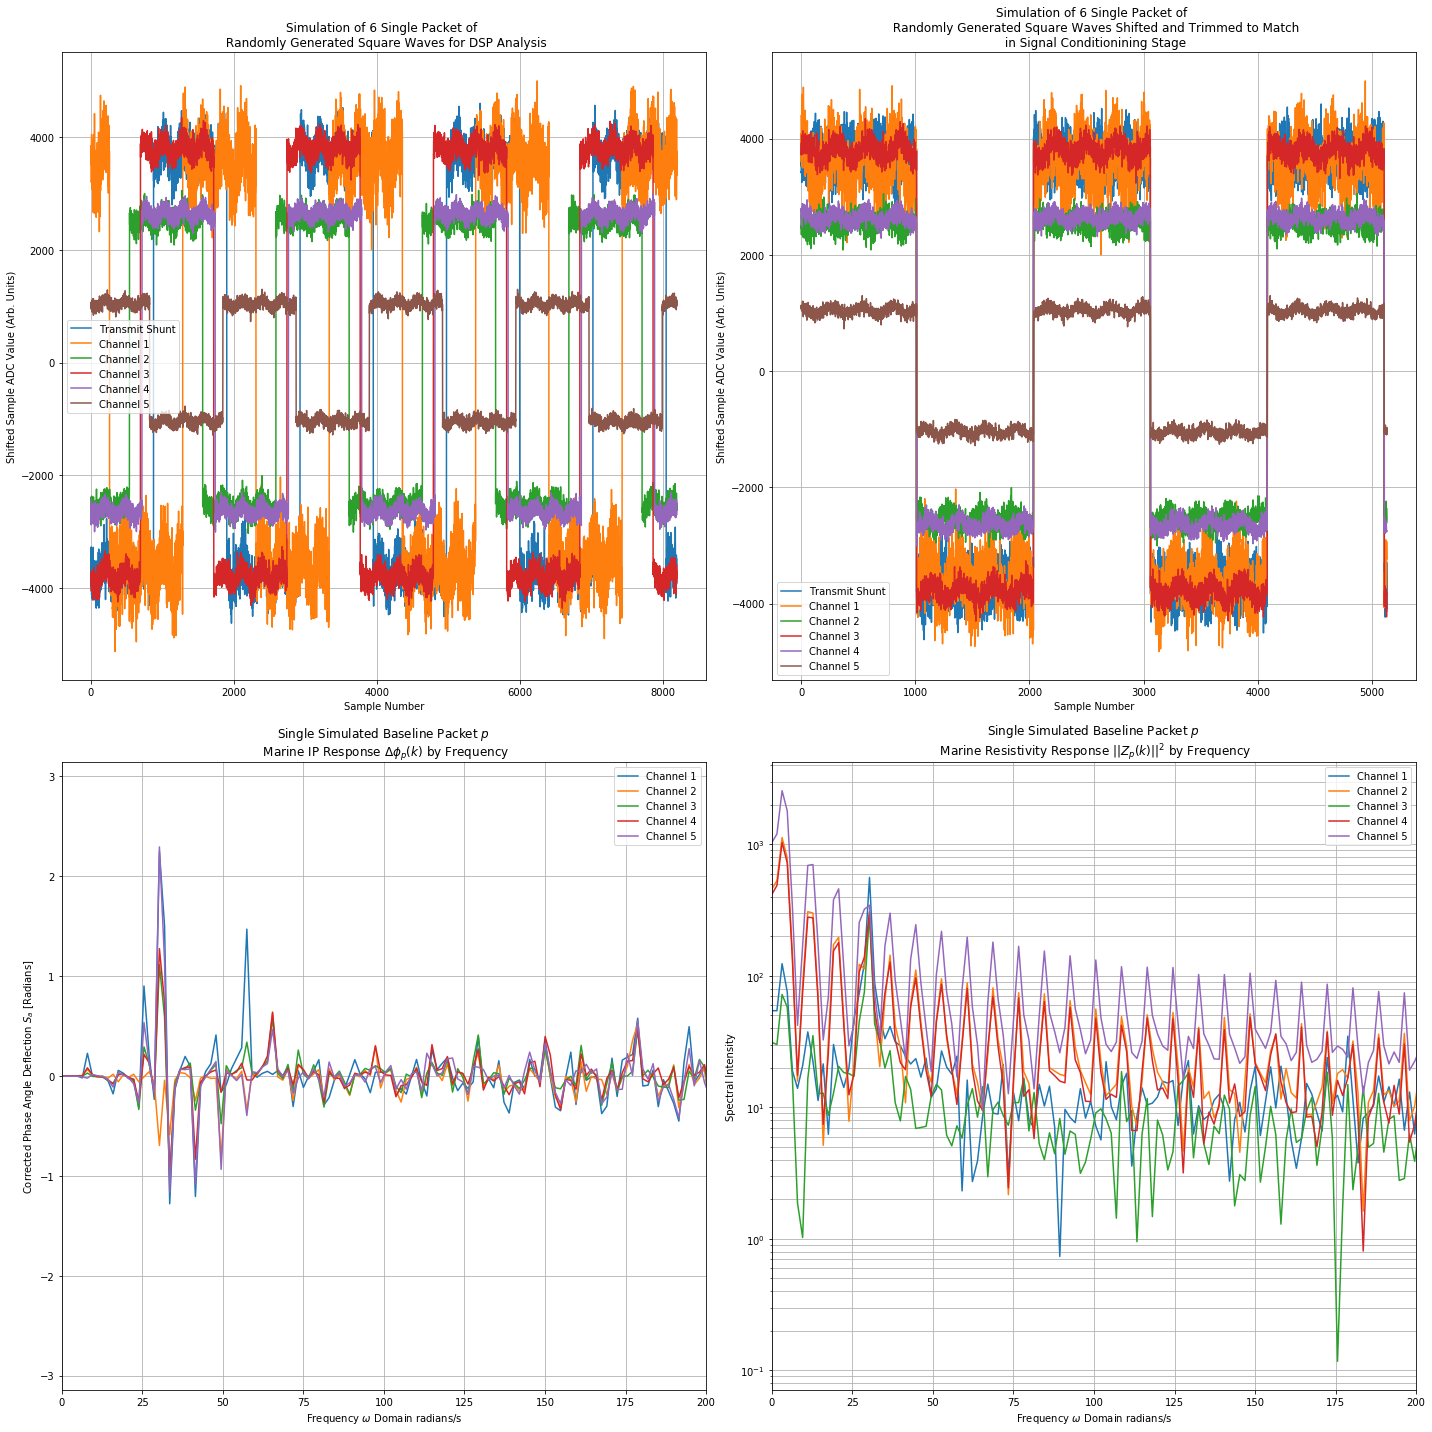

In [594]:
plot_phase_shift_and_magnitude(baseline_packets, conditioned_signals, k, marine_ip_k, marine_r_k)

## Baseline Generation Continued:  Simulating a Multi-Packet Baseline 
with square waves of slightly variable amplitude, random time-offset and more-or-less fixed noise level.

In [595]:
n_samples_base = 8192 # per packet
# p_packets = 150  # number of packets to generate and average
p_packets_base = 100  # number of packets to generate and average


# # Simulate 6 channels of baseline noisy data with variable offsets within certain ranges.
q_channels = 6  # number of channels in each packet with simulated waveforms.
T = 1 # Sampling period (seconds)
f_s = 8192  # [Samples/second]
# Random parameter ranges
base_offset_max = 4000
base_offset_min = -4000
base_amp_max = 4000
base_amp_min = 500

baseline_packet_set = np.empty((n_samples_base, q_channels, p_packets_base))

for p in range(0, p_packets_base):
    t_domain, baseline_packet_set[:, :, p] = simulate_squares(q_channels, base_offset_max, base_offset_min, base_amp_max, base_amp_min)

average_baseline_packet = np.average(baseline_packet_set, axis=2)
average_baseline_packet.shape
    

(8192, 6)

## To Highlight the Order of Operations:

In [596]:
k, conditioned_baseline, baseline_ip_response, baseline_r_response = packet_dsp(t_domain, average_baseline_packet, T, f_s, filter_order=4, filter_cut=200)

/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/anaconda3/lib/python3.6/site-packages/numpy/

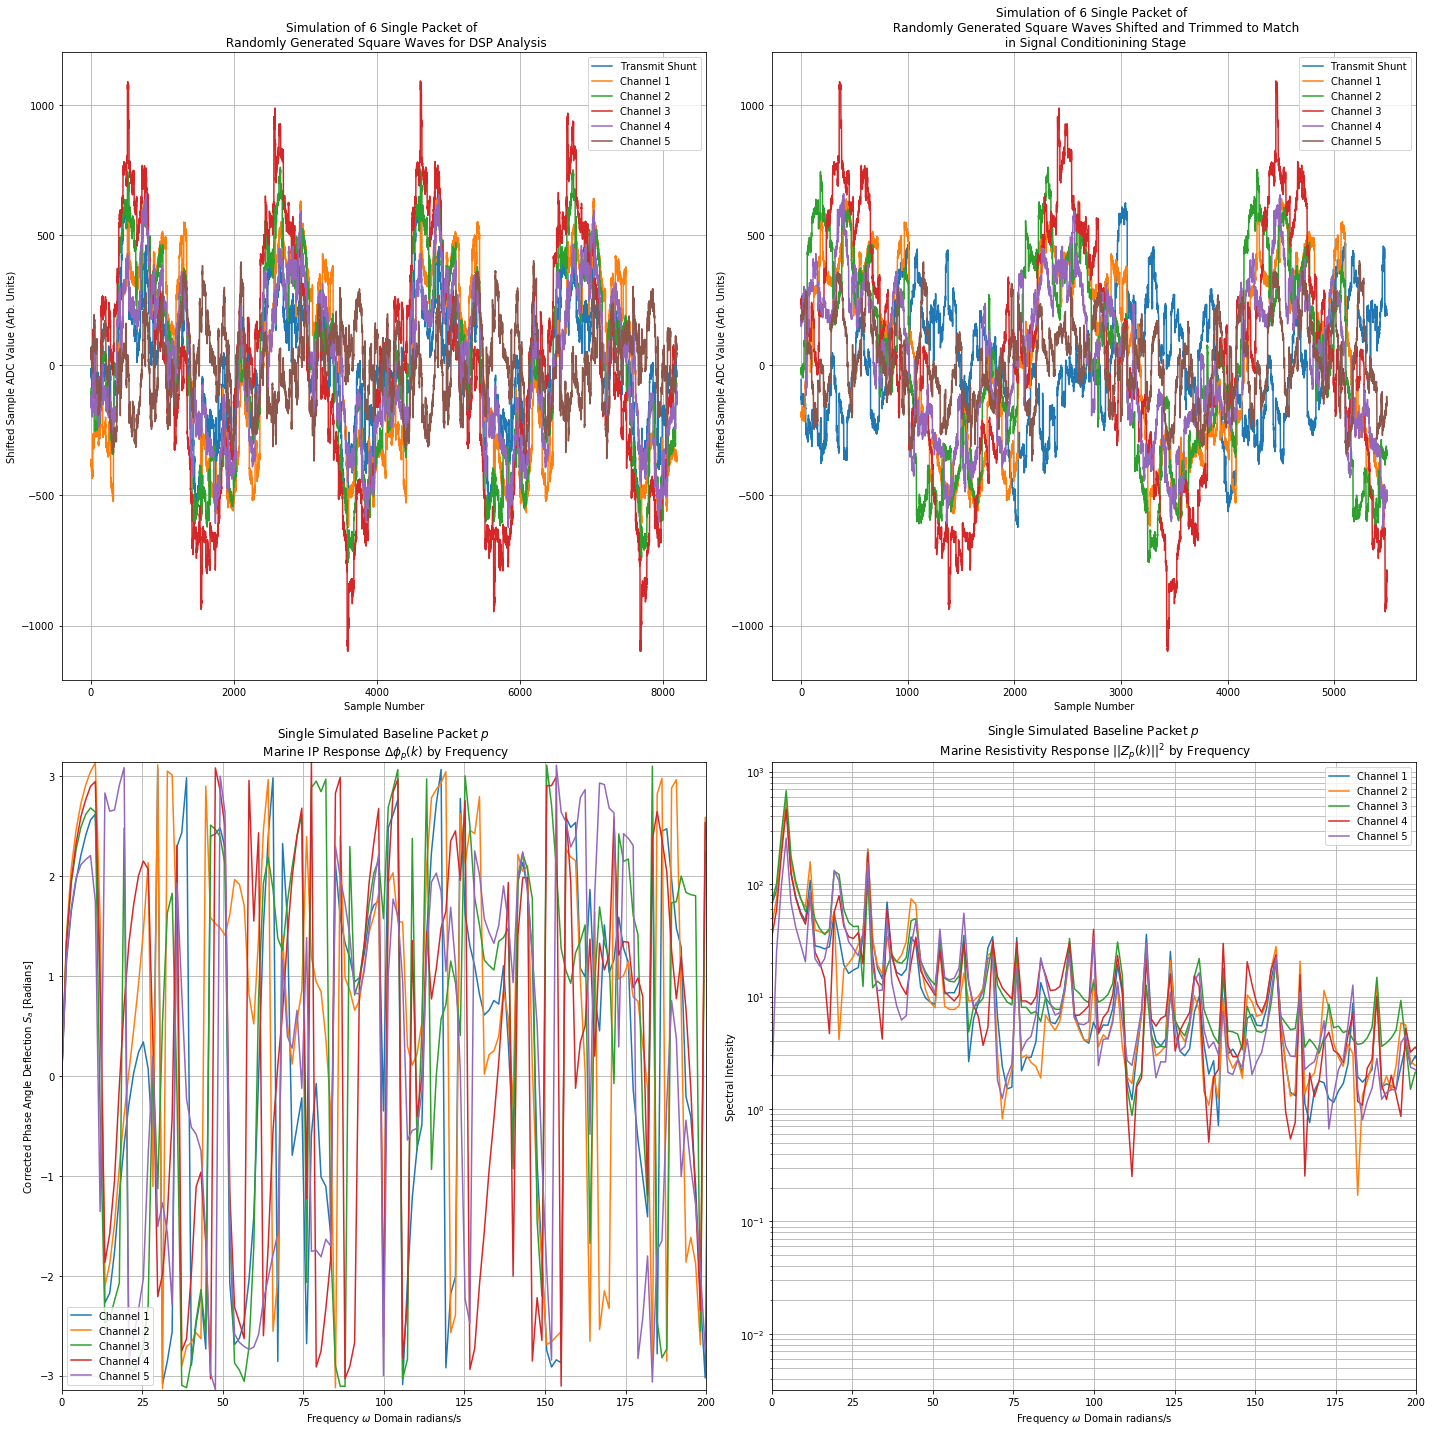

In [597]:
plot_phase_shift_and_magnitude(average_baseline_packet, conditioned_baseline, k, baseline_ip_response, baseline_r_response)

Notice how this data set is substantially messier, even **with triggering logic** because the spectrum is applied after the time series are averaged.  Strangely, the Marine resistivity data looks a bit tighter in this simulation.  Keep in mind, the conditions are more or less random between the packets -- however this highlights the need for properly ordered DSP core functions, as the following will show.

In [598]:
# more-or-less-global constants
tau = np.float(T / f_s)
# 
k_domain = fft.rfftfreq(n_samples, tau)
# options
maxfreq = 200 # maximum frequency for truncating spectra (Hz)

# array definitions for simulated data
baseline_packet_set = np.empty((n_samples, q_channels, p_packets_base))

# 
mip_set= np.empty((maxfreq, q_channels, p_packets_base))
mr_set = np.empty((maxfreq, q_channels, p_packets_base))

# stack all the packets into the p_packets_base axis of the sets. 
for p in range(0, p_packets_base):
    # one would replace the following line with a call to the raw data for packet-p in the baseline set. 
    t_domain, baseline_packet_set[:, :, p] = simulate_squares(q_channels, base_offset_max, base_offset_min, base_amp_max, base_amp_min)
    _, _, mip, mr = packet_dsp(t_domain, baseline_packet_set[:, :, p], T, f_s, filter_order=4, filter_cut=200)
    mip_set[:, :, p] = mip[:maxfreq]
    mr_set[:, :, p] = mr[:maxfreq]

# average along the p_packets_base axis. Generates a (k_frequencies X q_channels) array of real values. 
avg_ip_response = np.average(mip_set, axis=2)
avg_r_response = np.average(mr_set, axis=2)

print(f"Packet Generation and Averaging Completed for {p_packets_base} baseline packets!")

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part


Packet Generation and Averaging Completed for 100 baseline packets!


In [599]:
def plot_only_phase_shift_and_z_mag(k_domain, ip_freqresp, z_freqresp, maxfreq, avg=False, hz=False):
    """ 
    .. function::
    .. description:: Plots the real and imaginary parts of each spectrum in 4 subplots. 
    :param truncated_frequency_domain:
    :param truncated_ip_freqresp:
    :param truncated_z_freqresp:
    :param avg: default False
    :return None:
    """
    
    number_of_channels = ip_freqresp.shape[-1]
    frequencies = k_domain[:maxfreq]
    
    if avg:
        avg_or_sing = "Average"
        packet_type = "{avg}"
    else:
        avg_or_sing = "Single"
        packet_type = "{p}"
        
    if hz:
        freq_unit = "Hz"
    else:
        freq_unit = "Radians/s"
        
    plt.figure(figsize=(15, 10))
    
    # Real Component of Phase Shift
    plt.subplot(121)
    for q in range(1, number_of_channels):
        plt.plot(frequencies, ip_freqresp[:, q], label='Channel %s' % q)
    plt.title(f"Real Component of {avg_or_sing} Simulated Baseline Packet $p$ \n Marine IP Response $\Delta\phi_{packet_type} (k)$")
    plt.xlabel(f'Frequency [{freq_unit}]')
    plt.ylabel("Phase Shift [Radians]")
    plt.xlim(0, maxfreq)
    plt.grid(True) 
    plt.legend()

    # Real Compoenent of ||Z||^2 across all channels
    plt.subplot(122)
    for q in range(1, number_of_channels):
        plt.plot(frequencies, z_freqresp[:, q], label='Channel %s' % q)
    plt.title(f"Simulated {avg_or_sing} Packet $p$ \n Marine Resistivity Response $||Z_{packet_type} (k)||^{2}$ by Frequency")
    plt.xlabel(f'Frequency [{freq_unit}]')
    plt.ylabel('Spectral Intensity')
    plt.xlim(0, 200)
    plt.grid(which='both', axis='both') 
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    

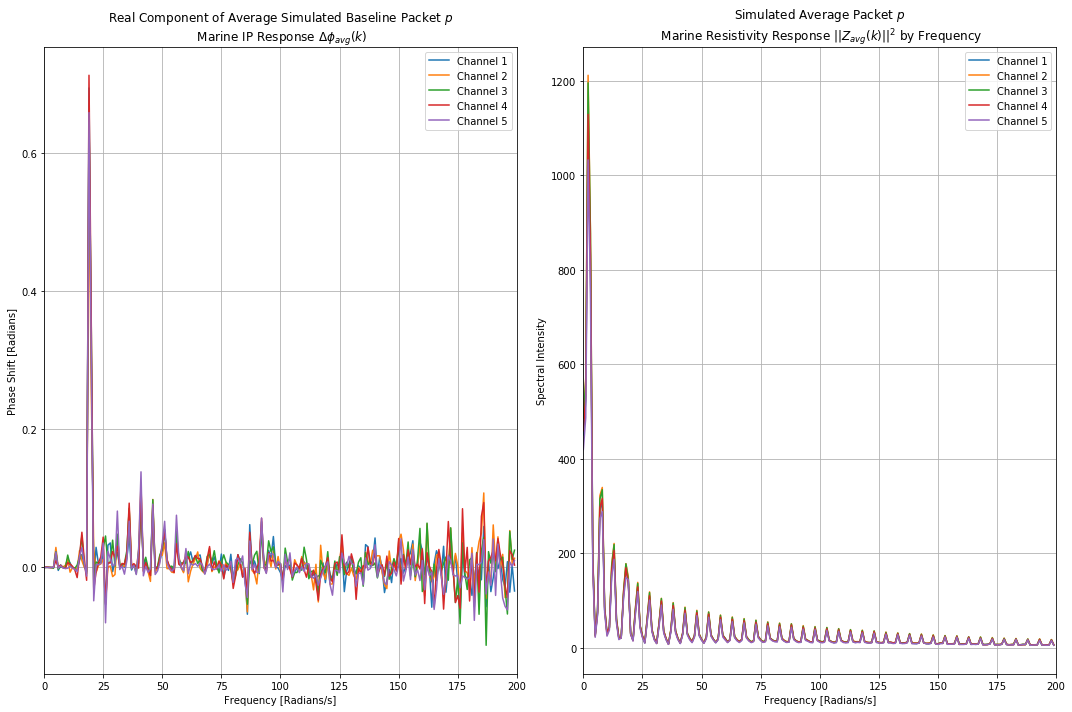

In [600]:
# plot_only_phase_shift_and_z_mag(k_domain, avg_ip_response, avg_r_response, maxfreq)
plot_only_phase_shift_and_z_mag(k_domain, avg_ip_response, avg_r_response, maxfreq, avg=True)

## Generate a Variable Simulation "Measurement Set"
Creating one more set of packets, maybe 20 or so, with random values again but having a constrained phase offset, we can test baseline subtraction.

In [601]:
n_samples_meas = 8192 # per packet
p_packets_meas = 2 # number of packets to generate and average
# Simulate 6 channels of baseline noisy data with variable offsets within certain ranges.
q_channels_meas = 6  # number of channels in each packet with simulated waveforms.
# T_meas = 1 # Sampling period (seconds)
# f_s = 8192  # [Samples/second]
# Random parameter ranges
base_offset_max_meas = 4000
base_offset_min_meas = -4000
base_amp_max_meas = 4000
base_amp_min_meas = 500
measurement_packet_set = np.empty((n_samples, q_channels, p_packets))

for p in range(0, p_packets):
    t_domain, measurement_packet_set[:, :, p] = simulate_squares(q_channels, base_offset_max, base_offset_min, base_amp_max, base_amp_min)
    

In [602]:
# take one of these packets and subtract the baseline, say packet 0
measurement_packet_1 = measurement_packet_set[:, :, 0]

In [603]:
# perform DSP on this packet having 6 channels. 
k, conditioned_packet_1, packet_1_ip_response, packet_1_r_response = packet_dsp(t_domain, measurement_packet_1, T, f_s, filter_order=4, filter_cut=200)

/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/anaconda3/lib/python3.6/site-packages/numpy/

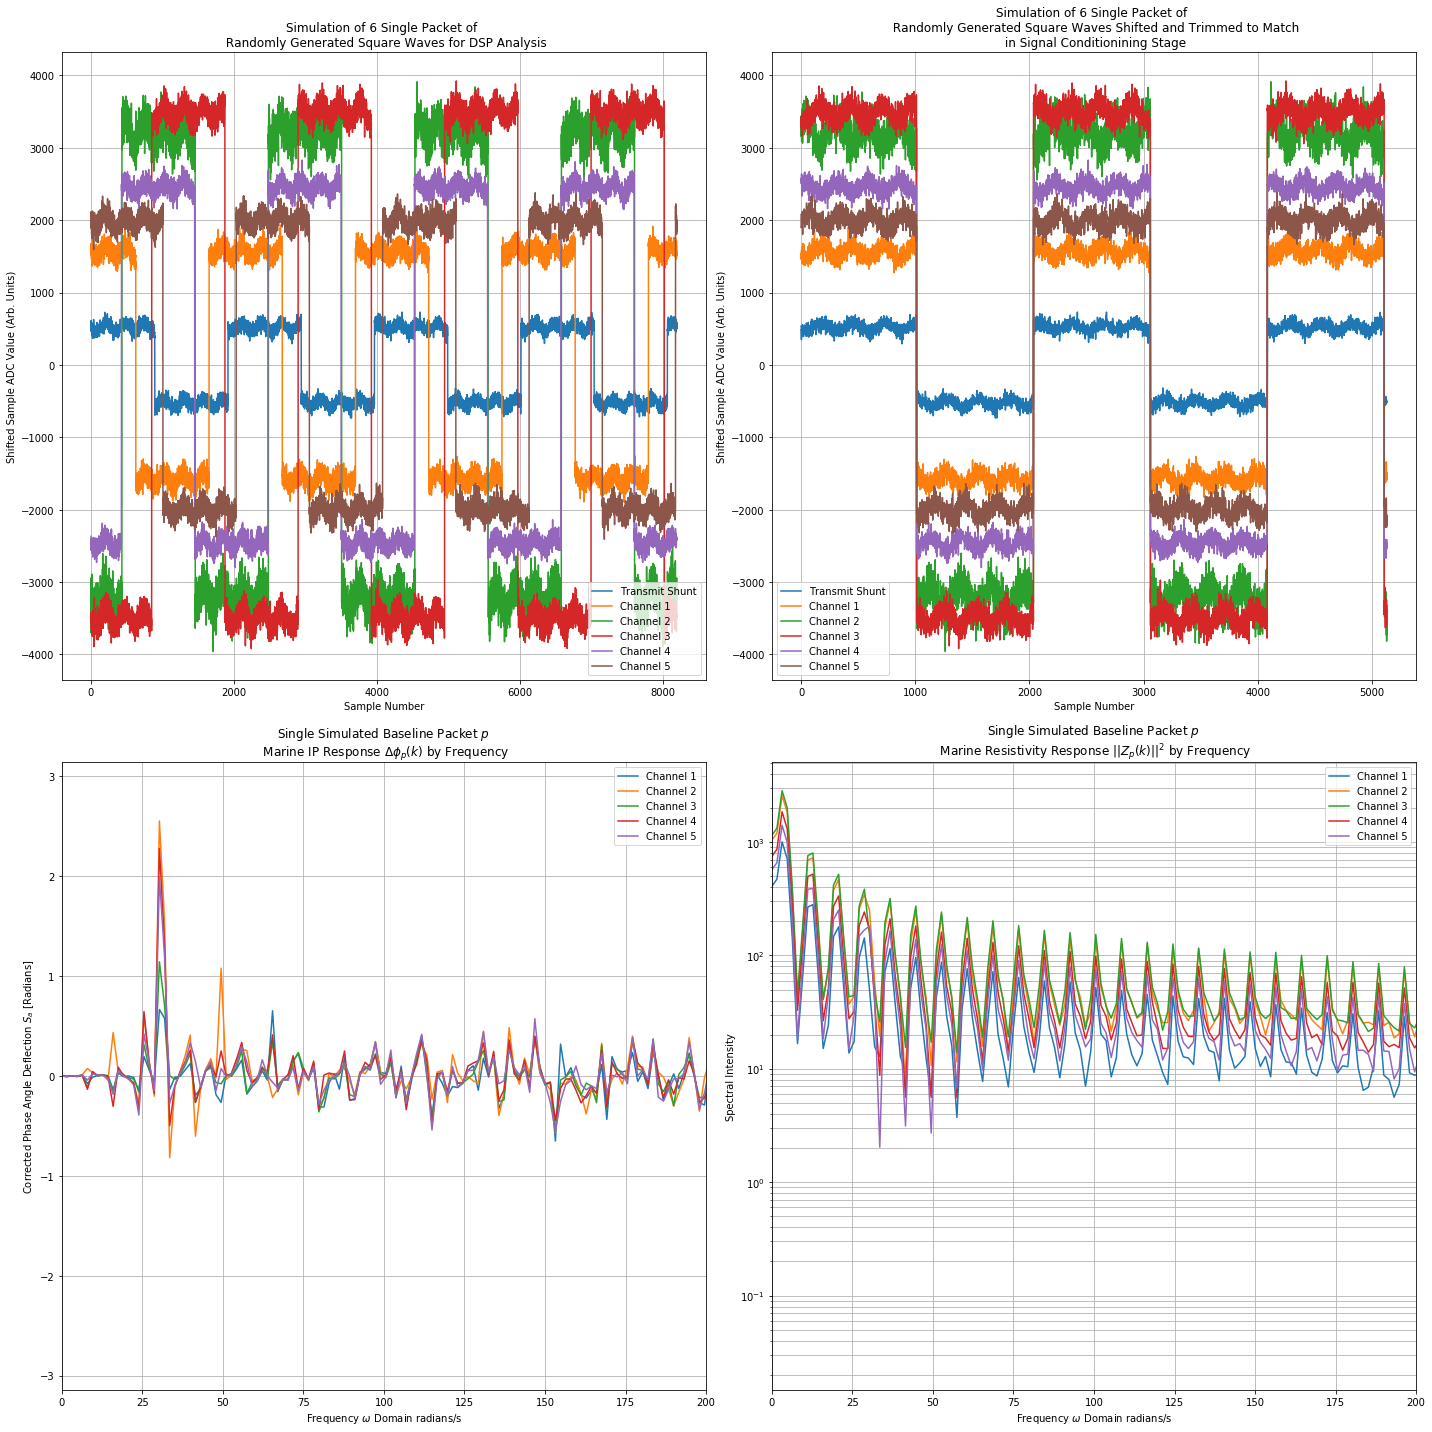

In [604]:
# plot the packet BEFORE average baseline subtraction:
plot_phase_shift_and_magnitude(measurement_packet_1, conditioned_packet_1, k, packet_1_ip_response, packet_1_r_response)

In [605]:
def subtract_baseline(measurement_packet_spectrum, avg_frequency_response, maxfreq):
    """
    .. description:: works the same for both types of spectra. Simple subtraction 
    of the baselines, but with some truncating to ensure they're the same dimemsions for 
    broadcasting. 
    """
    return measurement_packet_spectrum[:maxfreq] - avg_frequency_response

In [606]:
packet_1_ip_base_subtracted = subtract_baseline(packet_1_ip_response, avg_ip_response, maxfreq)

In [607]:
packet_1_r_base_subtracted = np.abs(subtract_baseline(packet_1_r_response, avg_r_response, maxfreq))

/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


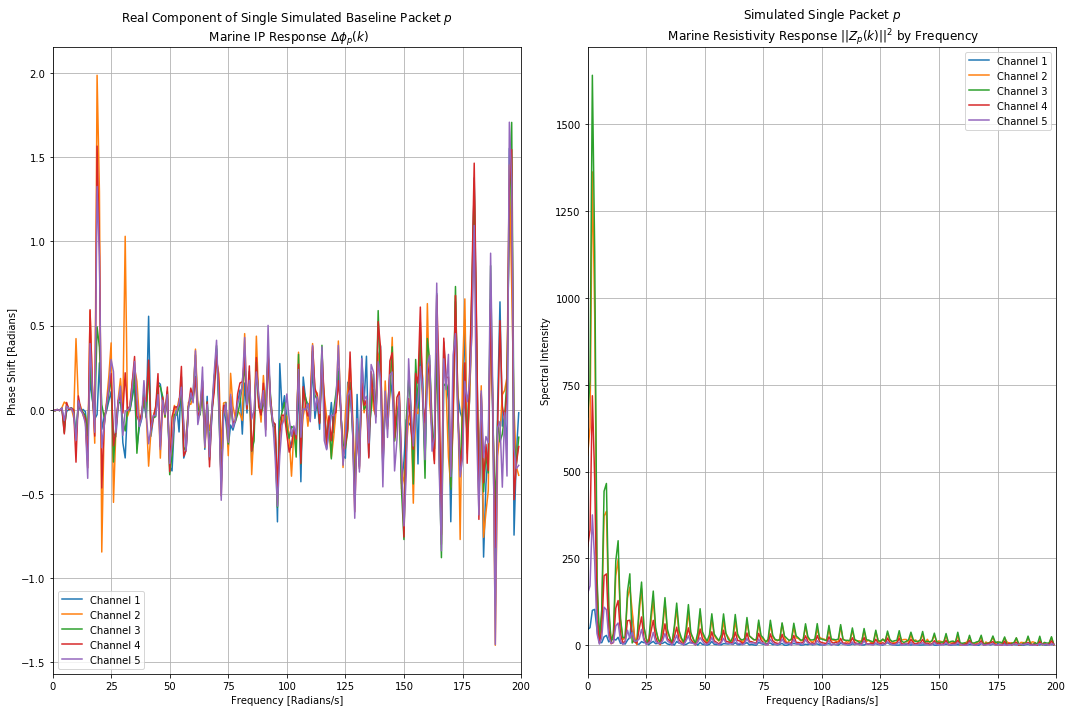

In [608]:
 plot_only_phase_shift_and_z_mag(k_domain, packet_1_ip_base_subtracted, packet_1_r_base_subtracted, maxfreq, avg=False)

At this point, normalizing the frequency spectra seems like the way to go to clean things up even further.  The two spectra above still show less variance than the earlier spectra generated by the data, but it can probably be made better with the introduction of normed amplitudes in the phase difference such that common frequency responses between baseline and measurement are fully cancelled out. 

Also, it is again important to note here that the data to this point has been completely simulated using random processes, so we do not expect any particular patterns to emerge yet. 

Another possibility is taking the normalized coherence between the two spectra or looking at other ways of comparing the normalized densities between the spectra. 

First, it is simplest to just compute the norms of the waveforms and normalize them against one another to scale up or down. Then the baseline removal should be far more effective and highlight only the phase shift frequency repsonses that differ between the two (average and measurement) signals. 

## Normalizing the spectra before performing a baseline subtraction:

In [609]:
def subtract_baseline_norms(meas, base, maxfreq):
    import numpy.linalg as linalg
    meas_norm = linalg.norm(meas)
    base_norm = linalg.norm(base)
    normed_meas = np.divide(meas, meas_norm)
    normed_base = np.divide(base, base_norm)
    return normed_meas[:maxfreq] - normed_base

In [610]:
packet_1_ip_base_norms_subtracted = subtract_baseline_norms(packet_1_ip_response, avg_ip_response, maxfreq)
packet_1_r_base_norms_subtracted = np.abs(subtract_baseline_norms(packet_1_r_response, avg_r_response, maxfreq))

In [611]:
def convert_rads_to_hertz(frequency_domain):
    """
    :param frequency_domain: Resulting frequency domain from fft.rfftfreq function.
    """
#     rad_s_per_hz = 0.159154943091895000 # rads/Hz
    hz_per_rad_s = 2 * np.pi
    hertz_values = frequency_domain * hz_per_rad_s
    return hertz_values

/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


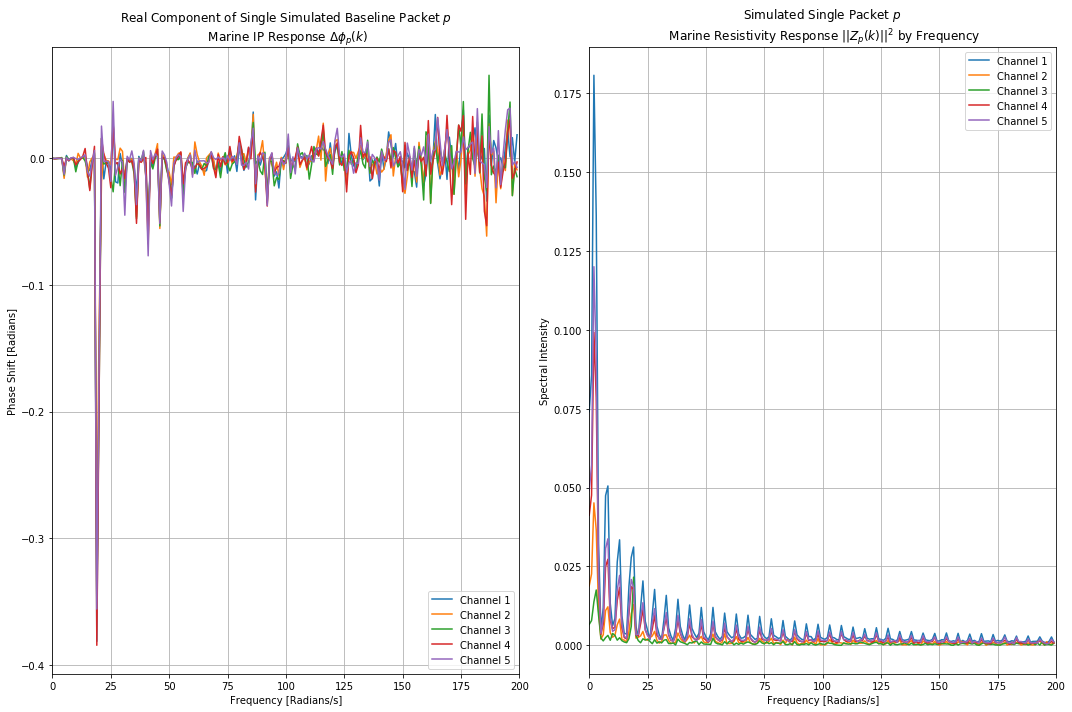

In [612]:
freqs_hz = convert_rads_to_hertz(k_domain)
# plot_only_phase_shift_and_z_mag(freqs_hz, packet_1_ip_base_norms_subtracted, packet_1_r_base_norms_subtracted, maxfreq, avg=False, hz=True)
plot_only_phase_shift_and_z_mag(k_domain, packet_1_ip_base_norms_subtracted, packet_1_r_base_norms_subtracted, maxfreq, avg=False, hz=False)

## Now to find anomalies: 
It's cleaner, but still obviously a bit messy in the phase domain.